In [ ]:
import json
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

# from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from pydantic import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

  
graph_builder = StateGraph(State)
memory = MemorySaver()

# llm = ChatAnthropic(model="claude-3.5-sonnet-20240620")
llm = ChatOpenAI(model='gpt-3.5-turbo')
tavily_search = TavilySearchResults(
                max_results=2,
                include_answer=True,
                include_raw_content=True,
                include_images=True
            )
tools = [tavily_search, RequestAssistance]
llm_with_tools = llm.bind_tools(tools)

# Simple chat node
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

graph_builder.add_node('chatbot', chatbot)
graph_builder.add_node('tools', ToolNode(tools=tools))

/Users/karramak/Documents/Work/Playground/langchain_project/langchainproj/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
from langchain_core.messages import AIMessage, ToolMessage

def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

In [3]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)

graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

In [4]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=memory, interrupt_before=['human'])

In [5]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_7NL5ASjwNoUdv8UwQnU8xQoe)
 Call ID: call_7NL5ASjwNoUdv8UwQnU8xQoe
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/", "content": "Overview¶. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence. LangGraph allows you to define flows that involve cycles, essential for most agentic architectures, differentiating it from DAG-based solutions."}, {"url": "https://www.datacamp.com/tutorial/langgraph-

In [6]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like an exciting project! Building an autonomous agent using LangGraph can be a fascinating endeavor. If you need any further assistance, resources, or guidance while working on your project, feel free to ask. Good luck with creating your autonomous agent with LangGraph!


In [8]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 3:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


In [10]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/", "content": "Overview¶. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence. LangGraph allows you to define flows that involve cycles, essential for most agentic architectures, differentiating it from DAG-based solutions."}, {"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with nodes, edges, and state management."}]
================================== Ai Message ============================

In [9]:
print(to_replay.next)
print(to_replay.config)

('chatbot',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd814d-ff93-6d42-8002-86d894d62459'}}


In [7]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

In [8]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd8109-dcc5-6192-8002-fcbf18207762'}}

In [9]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='c21fe1fa-66e0-41f1-80af-f53e01c41ac3'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_32r0Wxgu4F1VbEOLyG4L73qR', 'function': {'arguments': '{"request":"I need expert guidance for building an AI agent."}', 'name': 'RequestAssistance'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 166, 'total_tokens': 191, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f80190c9-e78d-4ed5-9527-597cbc9d25ca-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': '

In [8]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': 'call_KI8Vwk33DOjd5Zi1yQBUSU8f',
  'type': 'tool_call'}]

In [10]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts recommend using LangGraph to build your AI agent. It is a reliable and extensible platform for creating sophisticated agents.


In [9]:
from langchain_core.messages import AIMessage, ToolMessage
answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]
new_messages[-1].pretty_print()
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='a5555bf9-169d-45e9-a6e6-670c6b6a3093', tool_call_id='call_KI8Vwk33DOjd5Zi1yQBUSU8f'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='52e6a2a2-d7e4-4863-9670-71a8c23b23b5')]


In [10]:
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])



Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='a5555bf9-169d-45e9-a6e6-670c6b6a3093', tool_call_id='call_KI8Vwk33DOjd5Zi1yQBUSU8f'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='52e6a2a2-d7e4-4863-9670-71a8c23b23b5')]


In [11]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd7ef5-9d45-66cc-8004-7daa9256b5c9'}}

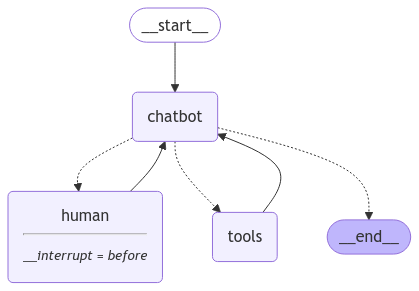

In [5]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='a5555bf9-169d-45e9-a6e6-670c6b6a3093', tool_call_id='call_KI8Vwk33DOjd5Zi1yQBUSU8f'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='52e6a2a2-d7e4-4863-9670-71a8c23b23b5'), AIMessage(content="I'm an AI expert!", additional_kwargs={}, response_metadata={}, id='6af14920-5113-4551-b7ed-80ae00683c18')]
()


In [14]:
# Overwrite state and/or previous messages
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_dhUmpTr5n50XpoLdExUMOhfN)
 Call ID: call_dhUmpTr5n50XpoLdExUMOhfN
  Args:
    query: LangGraph


In [15]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-587a8762-f5ef-4ddf-825d-8060c942c522-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'call_dhUmpTr5n50XpoLdExUMOhfN', 'type': 'tool_call'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'call_dhUmpTr5n50XpoLdExUMOhfN', 'type': 'tool_call'}
Message ID run-587a8762-f5ef-4ddf-825d-8060c942c522-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': 'call_dhUmpTr5n50XpoLdExUMOhfN',
  'type': 'tool_call'}]

In [16]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_dhUmpTr5n50XpoLdExUMOhfN)
 Call ID: call_dhUmpTr5n50XpoLdExUMOhfN
  Args:
    query: LangGraph human-in-the-loop workflow
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://blog.langchain.dev/making-it-easier-to-build-human-in-the-loop-agents-with-interrupt/", "content": "Making it easier to build human-in-the-loop agents with interrupt Making it easier to build human-in-the-loop agents with interrupt Today, we’re excited to announce a new method to more easily include human-in-the-loop steps in your LangGraph agents: interrupt How we built LangGraph for human-in-the-loop workflows interrupt: a new developer experience for human-in-the-loop We’ve had a few ways of building human in the loop interactions before (breakpoints, NodeInterrupt). When building human-in-the-loop into Pyt